In [1]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
from datetime import datetime
import tqdm # To get status line when scraping
from scipy.spatial import KDTree
from geopy.distance import geodesic
import re
import time
from selenium.webdriver.support.ui import WebDriverWait
from bs4 import BeautifulSoup
import requests
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
import matplotlib.pyplot as plt




Jeg starter med at hente stationer 
fra DSBs hjemmeside

In [2]:
url_station = "https://www.dsb.dk/api/stations/getstationlist"
response_station = requests.get(url_station) # submit query with `get` and save response as object
response_station_json = response_station.json() # convert response to a list of dicts
station_df=pd.DataFrame(response_station_json)


Jeg tilføjer variable i stations_df med koordinater

In [3]:
station_df['stationLatitude'] = station_df['stationLatitude'].str.replace(',', '.').astype(float)
station_df['stationLongitude'] = station_df['stationLongitude'].str.replace(',', '.').astype(float)

In [4]:
#Opretter selvstændig liste
station_names=station_df['stationName']

Jeg fjerner Station fra alle navne, da man ikke kan søge med det på Banedanmarks hjemmeside

In [5]:
# Function to clean station names
def clean_station_name(name):
    # Remove ' Station' if it exists
    return name.replace(' Station', '')

# Apply the function to the list
cleaned_station_names = [clean_station_name(name) for name in station_names]

# Print the cleaned list
#print(cleaned_station_names)

In [6]:
station_df['stationName'] = [clean_station_name(name) for name in station_df['stationName']]


In [7]:
station_df['stationName'] = [
    'Viby Jylland' if station == 'Viby J' else
    'Nivå' if station == 'Nivå station' else
    'Højby (Fyn)' if station == 'Højby Fyn station' else
    # 'CPH Lufthavn ✈︎' if station == 'Københavns Lufthavn (CPH Airport)' else
    'Viby Sj' if station == 'Viby Sjælland' else
    'Aalborg Lufthavn ✈︎' if station == 'Aalborg Lufthavn' else
    station 
    for station in station_df['stationName']
]


In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(station_df)

,stationName,stationUrl,stationLatitude,stationLongitude,tags
0,Albertslund,http://www.dsb.dk/kundeservice/stationer/alber...,55.658108,1.235314e+01,"[DSB 7-Eleven, Aflåst cykelparkering]"
1,Alken,http://www.dsb.dk/kundeservice/stationer/alken/,56.052392,9.845708e+00,[]
2,Allerød,http://www.dsb.dk/kundeservice/stationer/allerod/,55.870613,1.235681e+01,[Aflåst cykelparkering]
3,Arden,http://www.dsb.dk/kundeservice/stationer/arden/,56.769733,9.859934e+00,[]
4,Asnæs,http://www.dsb.dk/kundeservice/stationer/asnas/,55.809927,1.150329e+01,[]
5,Aulum,http://www.dsb.dk/kundeservice/stationer/aulum/,56.265253,8.788423e+00,[]
6,Avedøre,http://www.dsb.dk/kundeservice/stationer/avedore/,55.625400,1.245410e+01,[]
7,Bagsværd,http://www.dsb.dk/kundeservice/stationer/bagsv...,55.761223,1.245415e+01,[]
8,Ballerup,http://www.dsb.dk/kundeservice/stationer/balle...,55.729635,1.235893e+01,"[DSB 7-Eleven, Aflåst cykelparkering]"
9,Bedsted Thy,http://www.dsb.dk/kundeservice/stationer/bedst...,56.806831,8.405832e+00,[]


Jeg ændre manuelt nogle navne, så hjememsiden er i stand til at finde dem. 

In [9]:
cleaned_station_names = ['Nivå' if station == 'Nivå Station' else 
                         'Viby Jylland' if station == 'Viby J' else 
                         'Højby (Fyn)' if station == 'Højby Fyn station' else 
                         'CPH Lufthavn ✈︎' if station == 'Københavns Lufthavn (CPH Airport)' else 
                         'Viby Sj' if station == 'Viby Sjælland' else 
                         'Aalborg Lufthavn ✈︎' if station == 'Aalborg Lufthavn' else  
                         station for station in cleaned_station_names]

In [10]:
keys_to_remove = [
    'Frederiksberg',
    'Faaborg Rutebilstation',
    'Kerteminde',
    'Nivå station',
    'Nykøbing Mors',
    'Rudkøbing',
    'Ærøskøbing',
    'Aabenraa Rutebilstation'
]

# Assume dict_of_dfs is your dictionary of DataFrames
# Remove rows where 'Station' is in keys_to_remove
station_df = station_df[~station_df['stationName'].isin(keys_to_remove)]


In [14]:
#Åbner webdriver,  husk at vælge søgemaskine

# Initialize the Chrome WebDriver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

# URL to navigate to
url = 'https://mittog.dk/da'
driver.get(url)
wait = WebDriverWait(driver, 1)


In [15]:
#Kørt 08.08 #split alfabetisk
#knabstrup 08.14
# sjørring 08.17
# varde 08.20
#obs Højby (Fyn)
#KBH lufthavn
# Initialize a dictionary to store DataFrames
station_data= {}

# URL to navigate to
homepage_url = 'https://mittog.dk/da'

# Iterate through the filtered station IDs
for station in cleaned_station_names:
    try:
        # Navigate to the homepage at the start of each iteration
        driver.get(homepage_url)

        # Wait for the search box to be present and clickable, then interact with it
        soge = WebDriverWait(driver, 2).until(
            EC.element_to_be_clickable((By.ID, 'downshift-:r0:-input'))
        )
        soge.click()

        # Clear the input field before entering a new station ID
        soge.clear()

        # Send the station ID to the search box
        soge.send_keys(station)

        # Wait for the relevant button to be clickable, then click it
        button = WebDriverWait(driver, 2).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[role="tab"].css-9tac0x'))
        )
        button.click()

        # Add a sleep time to ensure the page has time to load completely before scraping
        time.sleep(2)  # Adjust the sleep time if necessary

        # Wait for the page to load and parse the page source with BeautifulSoup
        WebDriverWait(driver, 2).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div[role="row"]'))
        )
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')

        # Extract rows of data
        rows = soup.find_all('div', {'role': 'row'})

        # Extract the data from each row
        data = []
        for row in rows:
            cells = row.find_all('div', {'role': 'gridcell'})
            row_data = [cell.get_text(strip=True) for cell in cells]
            if row_data:  # Only add if row_data is not empty
                data.append(row_data)

        # Check if data was extracted successfully
        if data:
            print(f"Data extracted for station {station}")
        else:
            print(f"No data found for station {station}, continuing...")

        # Create a pandas DataFrame for the station
        df = pd.DataFrame(data, columns=['Train Number', 'Time', 'To', 'Track', 'Details'])

        # Store the DataFrame in the dictionary with the station ID as the key
        station_data[station] = df

    except Exception as e:
        print(f"Error processing station {station}: {e}")
        continue

# After processing all station IDs, quit the driver
driver.quit()


# Check results
for station, df in station_data.items():
    print(f"Station: {station}")
    print(df.head())  # Display the first few rows of the DataFrame

Data extracted for station Albertslund
Data extracted for station Alken
Data extracted for station Allerød
Data extracted for station Arden
Error processing station Asnæs: Message: 

Data extracted for station Aulum
Data extracted for station Avedøre
Data extracted for station Bagsværd
Data extracted for station Ballerup
Data extracted for station Bedsted Thy
Data extracted for station Bernstorffsvej
Data extracted for station Birk Centerpark
Data extracted for station Birkerød
Data extracted for station Bispebjerg
Data extracted for station Bjerringbro
Data extracted for station Bording
Data extracted for station Borris
Data extracted for station Borup
Data extracted for station Bramming
Data extracted for station Brande
Data extracted for station Bred
Data extracted for station Bredebro
Data extracted for station Brejning
Data extracted for station Brøndby Strand
Data extracted for station Brøndbyøster
Data extracted for station Brønderslev
Data extracted for station Brøns
Data extra

In [35]:
# Initialize to infinity to ensure any found value will be lower
min_train_time = float('inf')

for df in station_data.values():
    # Filter for rows where s_or_no == 0
    filtered_df = df[df['s_or_no'] == 0]
    
    # Convert the 'Time' column to numeric, forcing errors to NaN
    filtered_df['Time'] = pd.to_numeric(filtered_df['Time'], errors='coerce')
    
    # Drop rows where 'Time' is NaN (after conversion)
    filtered_df = filtered_df.dropna(subset=['Time'])
    
    # Find the minimum train_time in this filtered DataFrame
    if not filtered_df['Time'].empty:  # Ensure there's data to check
        min_value = filtered_df['Time'].min()
        if min_value < min_train_time:
            min_train_time = min_value

if min_train_time == float('inf'):
    print("No valid train_time values found with s_or_no == 0.")
else:
    print(f"The minimum train_time where s_or_no = 0 across all DataFrames is: {min_train_time}")


The minimum train_time where s_or_no = 0 across all DataFrames is: 0.05


In [25]:

# Convert each DataFrame in the dictionary to JSON format
my_json_data = {key: df.to_json(orient='records') for key, df in station_data.items()}

# Save the entire structure as a JSON file
with open('rå_scrape.json', 'w') as file:
    json.dump(my_json_data, file)

In [28]:
# # Initialize a list to store visited URLs
# visited_urls = []

# # URL to navigate to
# homepage_url = 'https://mittog.dk/da'

# # Initialize the WebDriver (make sure to specify the path to your WebDriver)
# driver = webdriver.Chrome()

# # Iterate through the filtered station IDs
# for station in cleaned_station_names:
#     try:
#         # Navigate to the homepage at the start of each iteration
#         driver.get(homepage_url)

#         # Wait for the search box to be present and clickable, then interact with it
#         soge = WebDriverWait(driver, 2).until(
#             EC.element_to_be_clickable((By.ID, 'downshift-:r0:-input'))
#         )
#         soge.click()

#         # Clear the input field before entering a new station ID
#         soge.clear()

#         # Send the station ID to the search box
#         soge.send_keys(station)

#         # Wait for the relevant button to be clickable, then click it
#         button = WebDriverWait(driver, 2).until(
#             EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[role="tab"].css-9tac0x'))
#         )
#         button.click()

#         # Add a sleep time to ensure the page has time to load completely before storing the URL
#         time.sleep(2)  # Adjust the sleep time if necessary

#         # Get the current URL after the page has loaded
#         current_url = driver.current_url

#         # Append the visited URL to the list
#         visited_urls.append(current_url)

#         print(f"Visited URL for station {station}: {current_url}")

#     except Exception as e:
#         print(f"Error processing station {station}: {e}")
#         continue

# # After processing all station IDs, quit the driver
# driver.quit()

# # Print all visited URLs
# print("List of visited URLs:")
# for url in visited_urls:
#     print(url)

In [27]:
# # Filter out any URLs that match the homepage URL
# visited_urls_2 = [url for url in visited_urls if url != homepage_url]

# # Print the filtered list of URLs
# print("Filtered list of URLs:")
# for url in visited_urls_2:
#     print(url)

In [26]:
# # Iterate through the list of URLs

# station_data_2 = {}

# # Iterate through the list of URLs
# for url in visited_urls_2:
#     try:
#         # Fetch the webpage content using requests
#         response = requests.get(url)
        
#         # Check if the request was successful
#         if response.status_code == 404:
#             print(f"URL not found (404): {url}")
#             continue
#         elif response.status_code != 200:
#             print(f"Failed to retrieve data from {url}, status code: {response.status_code}")
#             continue
        
#         # Parse the page source with BeautifulSoup
#         soup = BeautifulSoup(response.content, 'html.parser')

#         # Extract rows of data
#         rows = soup.find_all('div', {'role': 'row'})

#         # Extract the data from each row
#         data = []
#         for row in rows:
#             cells = row.find_all('div', {'role': 'gridcell'})
#             row_data = [cell.get_text(strip=True) for cell in cells]
#             if row_data:  # Only add if row_data is not empty
#                 data.append(row_data)

#         # Check if data was extracted successfully
#         if data:
#             print(f"Data extracted for URL {url}")
#         else:
#             print(f"No data found for URL {url}, continuing...")

#         # Derive the station name from the URL (assuming it's the last part of the URL)
#         station_name = url.rstrip('/').split('/')[-1]

#         # Create a pandas DataFrame for the station
#         df = pd.DataFrame(data, columns=['Train Number', 'Time', 'To', 'Track', 'Details'])

#         # Store the DataFrame in the dictionary with the station name as the key
#         station_data_2[station_name] = df

#     except Exception as e:
#         print(f"Error processing URL {url}: {e}")
#         continue

# # Now, station_data contains DataFrames keyed by station name extracted from the URLs

##Datacleaning

Her starter noget seriøs cleaning. Jeg indæstter whitespace for forsinkelser og tager den oprindelige afgang.

In [95]:
# Assuming station_data is your dictionary of DataFrames
for key in station_data:
    # Drop the specified columns from each DataFrame
    station_data[key] = station_data[key].drop(columns=['Minutes_to_next_train', 's_or_no'], errors='ignore')

print("Columns 'Minutes_to_next_train' and 's_or_no' have been removed from all DataFrames.")


Columns 'Minutes_to_next_train' and 's_or_no' have been removed from all DataFrames.


In [96]:
station_data

{'Albertslund':    Train Number   Time             To Track Details  Alphabetical_Range
 0             B   2min  Høje Taastrup     4                           1
 1            Bx   4min       Buddinge     3                           1
 2             B   8min          Farum     3                           1
 3             B  11min  Høje Taastrup     4                           1
 4            Bx  15min  Høje Taastrup     4                           1
 5             B  18min          Farum     3                           1
 6             B  22min  Høje Taastrup     4                           1
 7            Bx  23min       Buddinge     3                           1
 8             B  28min          Farum     3                           1
 9             B  31min  Høje Taastrup     4                           1
 10           Bx  36min  Høje Taastrup     4                           1
 11            B  38min          Farum     3                           1
 12           Bx  43min       Buddin

In [97]:
# Function to insert a whitespace in the middle of a string if it follows the format like '10.3110.33'
def insert_whitespace(time_str):
    match = re.match(r'^(\d{2}\.\d{2})(\d{2}\.\d{2})$', time_str)
    if match:
        return match.group(1) + ' ' + match.group(2)
    return time_str

# Iterate through each DataFrame in the dictionary
for station, df in station_data.items():
    # Apply the function to the 'Time' column
    df['Time'] = df['Time'].apply(insert_whitespace)

In [98]:
def remove_after_whitespace(time_str):
    return time_str.split(' ')[0]

# Iterate through each DataFrame in the dictionary
for station, df in station_data.items():
    # Apply the function to the 'Time' column
    df['Time'] = df['Time'].apply(remove_after_whitespace)

For regionaltoge omdanner jeg, så jeg i stedet for afgangstidspunk får miuntter til næste afgang. Jeg definerer tidspunkt ud fra alfabetet, da det tog lidt tid at køre koden.

In [113]:
# Function to normalize the time format to HH.MM
def normalize_time_format(time_str):
    # Check if the time is in the format H.MM (e.g., 8.46)
    if re.match(r'^\d{1}\.\d{2}$', time_str):
        return '0' + time_str  # Add a leading zero to make it HH.MM
    return time_str

# Function to check if the time is in the HH.MM format and calculate minutes from 08:08
def calculate_minutes_from_08(time_str):
    # Normalize the time format
    time_str = normalize_time_format(time_str)
    
    # Regular expression to check if the format is HH.MM
    if re.match(r'^\d{2}\.\d{2}$', time_str):
        hours, minutes = map(int, time_str.split('.'))
        # Calculate minutes from 08:08
        return (hours - 8) * 60 + (minutes - 8)
    else:
        return time_str  # Return the original string if it doesn't match the HH.MM format

# Function to apply the transformation to each DataFrame in the dictionary
def transform_station_data(station_data):
    for station, df in station_data.items():
        df['Minutes_to_next_train'] = df['Time'].apply(calculate_minutes_from_08)
    return station_data

# Apply the transformation to the station data
station_data = transform_station_data(station_data)


In [114]:
station_data

{'Albertslund':    Train Number   Time             To Track Details  Alphabetical_Range  \
 0             B   2min  Høje Taastrup     4                           1   
 1            Bx   4min       Buddinge     3                           1   
 2             B   8min          Farum     3                           1   
 3             B  11min  Høje Taastrup     4                           1   
 4            Bx  15min  Høje Taastrup     4                           1   
 5             B  18min          Farum     3                           1   
 6             B  22min  Høje Taastrup     4                           1   
 7            Bx  23min       Buddinge     3                           1   
 8             B  28min          Farum     3                           1   
 9             B  31min  Høje Taastrup     4                           1   
 10           Bx  36min  Høje Taastrup     4                           1   
 11            B  38min          Farum     3                           1 

In [115]:
#Her fjerner jeg 'min' fra s-tog og omdanner 1/2 til 0,5 

# Function to clean and convert the time variable
def clean_and_convert_minutes(value):
    if isinstance(value, str):
        if 'min' in value:
            value = value.replace('min', '').strip()  # Remove 'min'
        if value == '1/2':
            return 0.5  # Convert '1/2' to 0.5
        try:
            return float(value)  # Convert to float if possible
        except ValueError:
            return None  # Handle unexpected formats gracefully
    return float(value)  # If it's already a number, convert to float

# Apply the function to the 'Minutes_to_next_train' variable
def clean_minutes_variable(station_data):
    for station, df in station_data.items():
        df['Minutes_to_next_train'] = df['Minutes_to_next_train'].apply(clean_and_convert_minutes)
    return station_data

station_data=clean_minutes_variable(station_data)

In [103]:
# Function to determine the alphabetical range
def assign_alphabetical_range(station_name):
    prefix = station_name[:2].capitalize()  # Get the first two letters of the station name

    if 'Aa' <= prefix <= 'Kn':
        return 1
    elif 'Ko' <= prefix <= 'S':
        return 2
    elif 'Sa' <= prefix <= 'V':
        return 3
    elif prefix >= 'Va':
        return 4
    else:
        return None  # For any unexpected values, though it shouldn't be needed

# Function to apply the logic to the DataFrames
def categorize_stations_by_alphabet(station_data):
    for station, df in station_data.items():
        df['Alphabetical_Range'] = assign_alphabetical_range(station)
    
    return station_data

# Example usage with your station data
station_data = categorize_stations_by_alphabet(station_data)


In [105]:
# List of values to check in 'Train number'
values_to_check = ['A', 'B', 'C', 'D', 'E', 'F' , 'Bx', 'H']

# Iterate over each DataFrame in the dictionary
for key, df in station_data.items():
    # Create the new column based on the condition
    df['s_or_no'] = df['Train Number'].apply(lambda x: 1 if x in values_to_check else 0)


In [106]:
# Function to calculate the new column based on your conditions
def calculate_new_column(df):
    if df['s_or_no'].eq(1).any():  # Check if there are any rows with s_or_no = 1
        max_minutes = df.loc[df['s_or_no'] == 1, 'Minutes_to_next_train'].max()
        if max_minutes < 45:
            # Calculate 45 divided by the max value
            new_value = 45 / max_minutes
        else:
            new_value = 0
    else:
        new_value = 0

    # Add the new column with the calculated value for all rows
    df['Under_45_min'] = df['s_or_no'].apply(lambda x: new_value if x == 1 else 0)
    return df

# Apply the function to each DataFrame in the dictionary
for key, df in station_data.items():
    station_data[key] = calculate_new_column(df)


In [116]:
# Function to apply the subtraction based on Alphabetical_Range
def adjust_minutes_based_on_range(df):
    # Apply conditions based on the Alphabetical_Range
    df.loc[(df['s_or_no'] == 0) & (df['Alphabetical_Range'] == 2), 'Minutes_to_next_train'] -= 5
    df.loc[(df['s_or_no'] == 0) & (df['Alphabetical_Range'] == 3), 'Minutes_to_next_train'] -= 8
    df.loc[(df['s_or_no'] == 0) & (df['Alphabetical_Range'] == 4), 'Minutes_to_next_train'] -= 11
    return df

# Function to apply the adjustment to all DataFrames in the dictionary
def transform_station_data_with_adjustments(station_data):
    for station, df in station_data.items():
        station_data[station] = adjust_minutes_based_on_range(df)
    return station_data

# Apply the transformation to the station data
station_data = transform_station_data_with_adjustments(station_data)


In [108]:
#Kontrollerer regional station

# Access and print the value associated with the key "Silkeborg"
if "Silkeborg" in station_data:
    print("Value for 'Silkeborg':", station_data["Silkeborg"])
else:
    print("Key 'Silkeborg' not found in the dictionary.")

Value for 'Silkeborg':    Train Number   Time        To Track Details  Alphabetical_Range  \
0      RA  5310   8.47  Aarhus H     2                           3   
1     Rex  5611   8.49    Struer     1                           3   
2     Rex  5612   9.12  Aarhus H     2                           3   
3      RA  5321   9.14    Skjern     1                           3   
4      RA  5314   9.47  Aarhus H     2                           3   
5     Rex  5615   9.49    Struer     1                           3   
6     Rex  5616  10.12  Aarhus H     2                           3   
7      RA  5327  10.14    Skjern     1                           3   
8      RA  5320  10.47  Aarhus H     2                           3   
9     Rex  5619  10.49    Struer     1                           3   
10     RA  5333  11.14    Skjern     1                           3   
11     RA  5326  11.47  Aarhus H     2                           3   
12    Rex  5623  11.49    Struer     1                           3 

In [109]:
#Kontrollerer med s-tog

if "Dybbølsbro" in station_data:
    print("Value for 'Dybbølsbro':", station_data["Dybbølsbro"])
else:
    print("Key 'Dybbølsbro' not found in the dictionary.")

Value for 'Dybbølsbro':    Train Number   Time             To Track Details  Alphabetical_Range  \
0             C   0min  Frederikssund     4                           1   
1             A   0min       Hillerød     5                           1   
2            Bx   0min  Høje Taastrup     6                           1   
3             B   2min  Høje Taastrup     4                           1   
4             E   2min          Holte     5                           1   
5             E   4min           Køge   4-6                           1   
6             B   4min          Farum     3                           1   
7             H   5min      Østerport     3                           1   
8             A   6min        Hundige   4-6                           1   
9             C   8min    Klampenborg     3                           1   
10            A   9min       Hillerød     5                           1   
11            C   9min  Frederikssund   4-6                           1   
1

Nu beregner jeg, hvor mange afgange der er indenfor 45 minutter. Altså hvor mange afgange der er fra 08.15 til 09.00 tirsdag morgen i august. Jeg gemmer resultatet i en liste. 

In [117]:
# Function to check for negative values in the Minutes_to_next_train column across all DataFrames
def check_for_negative_values(station_data):
    for station, df in station_data.items():
        if (df['Minutes_to_next_train'] < 0).any():
            print(f"Negative values found in station '{station}'")
            print(df[df['Minutes_to_next_train'] < 0])
        else:
            print(f"No negative values in station '{station}'")

# Apply the check to your station data
check_for_negative_values(station_data)


No negative values in station 'Albertslund'
No negative values in station 'Alken'
No negative values in station 'Allerød'
No negative values in station 'Arden'
No negative values in station 'Aulum'
No negative values in station 'Avedøre'
No negative values in station 'Bagsværd'
No negative values in station 'Ballerup'
No negative values in station 'Bedsted Thy'
No negative values in station 'Bernstorffsvej'
No negative values in station 'Birk Centerpark'
No negative values in station 'Birkerød'
No negative values in station 'Bispebjerg'
No negative values in station 'Bjerringbro'
No negative values in station 'Bording'
No negative values in station 'Borris'
No negative values in station 'Borup'
No negative values in station 'Bramming'
No negative values in station 'Brande'
No negative values in station 'Bred'
No negative values in station 'Bredebro'
No negative values in station 'Brejning'
No negative values in station 'Brøndby Strand'
No negative values in station 'Brøndbyøster'
No ne

In [118]:
# Function to count rows that meet the condition in each DataFrame
def count_valid_departures(station_data):
    station_counts = []

    for station, df in station_data.items():
        # Filter rows with values between 0 and 45 inclusive
        count = df[(df['Minutes_to_next_train'] >= 0) & (df['Minutes_to_next_train'] <= 45)].shape[0]
        station_counts.append({'Station': station, 'Afgange': count})

    # Create a new DataFrame with the results
    result_df = pd.DataFrame(station_counts)

    # Add the additional observations
    additional_stations = [
        {'Station': 'Asnæs', 'Afgange': 2},
        {'Station': 'Dianalund', 'Afgange': 2},
        {'Station': 'Faxe Ladeplads', 'Afgange': 2},
        {'Station': 'Fredensborg', 'Afgange': 2},
        {'Station': 'Frederiksværk', 'Afgange': 5},
        {'Station': 'Gilleleje', 'Afgange': 2},
        {'Station': 'Havdrup', 'Afgange': 2},
        {'Station': 'Helsinge', 'Afgange': 2},
        {'Station': 'Højby (Sjælland)', 'Afgange': 2},
        {'Station': 'Høng', 'Afgange': 2},
        {'Station': 'Hårlev', 'Afgange': 3},
        {'Station': 'Lemvig', 'Afgange': 1},
        {'Station': 'Maribo', 'Afgange': 2},
        {'Station': 'Nakskov', 'Afgange': 1},
        {'Station': 'Nykøbing Sj', 'Afgange': 1},
        {'Station': 'Nærum', 'Afgange': 1},
        {'Station': 'Rødvig', 'Afgange': 1},
        {'Station': 'Sakskøbing', 'Afgange': 2},
        {'Station': 'Store Heddinge', 'Afgange': 2},
        {'Station': 'Svenstrup', 'Afgange': 2},
        {'Station': 'Søllested', 'Afgange': 2},
        {'Station': 'Nivå', 'Afgange': 9},
        {'Station': 'Højby Sjælland', 'Afgange': 2},
        {'Station': 'Havdrup', 'Afgange': 3},
        {'Station': 'Københavns Lufthavn (CPH Airport)', 'Afgange': 9},
    ]

    

    # Convert the list of dictionaries to a DataFrame and concatenate it with the result_df
    additional_df = pd.DataFrame(additional_stations)
    result_df = pd.concat([result_df, additional_df], ignore_index=True)

    return result_df

# Example usage
# Assuming station_data is your dictionary where each key is a station name and each value is a DataFrame
result_df = count_valid_departures(station_data)

# Show the result

In [119]:
# Assuming station_data is your dictionary of DataFrames
# Assuming station_data is your dictionary of DataFrames
under_45_min_list = []

for key, df in station_data.items():
    if not df.empty and 'Under_45_min' in df.columns:
        under_45_min_value = df.iloc[0]['Under_45_min']
        under_45_min_list.append((key, under_45_min_value))



In [120]:
# Step 1: Convert under_45_min_list to a DataFrame
under_45_min_df = pd.DataFrame(under_45_min_list, columns=['Station', 'Under_45_min'])

# Step 2: Merge under_45_min_df with result_df on the 'Station' column
merged_df = pd.merge(result_df, under_45_min_df, on='Station', how='left')

# Step 3: Update the Afgange_corrected column
merged_df['Afgange_corrected'] = merged_df.apply(
    lambda row: row['Afgange'] * row['Under_45_min'] if row['Under_45_min'] > 0 else row['Afgange'], axis=1
)

# Drop the 'Under_45_min' column if you no longer need it
merged_df.drop(columns=['Under_45_min'], inplace=True)

# Update result_df with the corrected data
result_df = merged_df

# Round the 'Afgange_corrected' column to the nearest whole number
result_df['Afgange_corrected'] = result_df['Afgange_corrected'].round()

# Show the updated result_df
result_df[30:40]


,Station,Afgange,Afgange_corrected
30,Carlsberg,20,28.0
31,Charlottenlund,9,9.0
32,Danshøj,21,34.0
33,Dybbølsbro,21,50.0
34,Dyssegård,15,15.0
35,Døstrup Sønderjylland,1,1.0
36,Egedal,10,10.0
37,Ejby,2,2.0
38,Emdrup,15,15.0
39,Engesvang,1,1.0


In [121]:
# Perform the left join
Afgang_data = station_df.merge(result_df, how='left', left_on='stationName', right_on='Station')



In [122]:
Afgang_data[80:100]

,stationName,stationUrl,stationLatitude,stationLongitude,tags,Station,Afgange,Afgange_corrected
80,Hee,http://www.dsb.dk/kundeservice/stationer/hee/,56.143609,8.286281e+00,[],Hee,1.0,1.0
81,Hellerup,http://www.dsb.dk/kundeservice/stationer/helle...,55.731116,1.256809e+01,"[DSB 7-Eleven, Aflåst cykelparkering]",Hellerup,6.0,6.0
82,Helsinge,http://www.dsb.dk/kundeservice/stationer/helsi...,56.023029,1.220511e+01,[],Helsinge,2.0,2.0
83,Helsingør,http://www.dsb.dk/kundeservice/stationer/helsi...,56.033549,1.261450e+01,[DSB 7-Eleven],Helsingør,7.0,7.0
84,Herfølge,http://www.dsb.dk/kundeservice/stationer/herfo...,55.417626,1.213726e+01,[Aflåst cykelparkering],Herfølge,2.0,2.0
85,Herlev,http://www.dsb.dk/kundeservice/stationer/herlev/,55.718902,1.244381e+01,"[DSB 7-Eleven, Aflåst cykelparkering]",Herlev,15.0,15.0
86,Herning Messecenter,http://www.dsb.dk/kundeservice/stationer/herni...,555643.908000,6.322569e+06,[],Herning Messecenter,0.0,0.0
87,Herning,http://www.dsb.dk/kundeservice/stationer/herning/,56.133219,8.977975e+00,"[DSB 7-Eleven, Aflåst cykelparkering]",Herning,1.0,1.0
88,Hillerød,http://www.dsb.dk/kundeservice/stationer/hille...,55.927123,1.231055e+01,"[DSB 7-Eleven, Aflåst cykelparkering]",Hillerød,5.0,5.0
89,Hinnerup,http://www.dsb.dk/kundeservice/stationer/hinne...,56.263705,1.005927e+01,[],Hinnerup,2.0,2.0


In [123]:
#Jeg tilføjer manuelt s-togsafgange til disse tre, da de som udgangspunkt selv henter reigonaltoge

Afgang_data.loc[Afgang_data['stationName'] == 'København H', 'Afgange_corrected'] += 39
Afgang_data.loc[Afgang_data['stationName'] == 'Østerport', 'Afgange_corrected'] += 31
Afgang_data.loc[Afgang_data['stationName'] == 'Nørreport', 'Afgange_corrected'] += 32

# Show the updated DataFrame
Afgang_data

,stationName,stationUrl,stationLatitude,stationLongitude,tags,Station,Afgange,Afgange_corrected
0,Albertslund,http://www.dsb.dk/kundeservice/stationer/alber...,55.658108,12.353142,"[DSB 7-Eleven, Aflåst cykelparkering]",Albertslund,14.0,14.0
1,Alken,http://www.dsb.dk/kundeservice/stationer/alken/,56.052392,9.845708,[],Alken,1.0,1.0
2,Allerød,http://www.dsb.dk/kundeservice/stationer/allerod/,55.870613,12.356810,[Aflåst cykelparkering],Allerød,9.0,9.0
3,Arden,http://www.dsb.dk/kundeservice/stationer/arden/,56.769733,9.859934,[],Arden,2.0,2.0
4,Asnæs,http://www.dsb.dk/kundeservice/stationer/asnas/,55.809927,11.503287,[],Asnæs,2.0,2.0
...,...,...,...,...,...,...,...,...
308,Ålholm,http://www.dsb.dk/kundeservice/stationer/alholm/,55.672309,12.493092,[Aflåst cykelparkering],Ålholm,20.0,20.0
309,Åmarken,http://www.dsb.dk/kundeservice/stationer/amarken/,55.640121,12.499651,[Aflåst cykelparkering],Åmarken,10.0,10.0
310,Aarhus H,http://www.dsb.dk/kundeservice/stationer/aarhu...,56.150272,10.204473,"[DSB Salg & Service, DSB 7-Eleven, Salg af udl...",Aarhus H,4.0,4.0
311,Årslev,http://www.dsb.dk/kundeservice/stationer/arslev/,55.302562,10.464334,[],Årslev,3.0,3.0


In [124]:
Afgang_data

,stationName,stationUrl,stationLatitude,stationLongitude,tags,Station,Afgange,Afgange_corrected
0,Albertslund,http://www.dsb.dk/kundeservice/stationer/alber...,55.658108,12.353142,"[DSB 7-Eleven, Aflåst cykelparkering]",Albertslund,14.0,14.0
1,Alken,http://www.dsb.dk/kundeservice/stationer/alken/,56.052392,9.845708,[],Alken,1.0,1.0
2,Allerød,http://www.dsb.dk/kundeservice/stationer/allerod/,55.870613,12.356810,[Aflåst cykelparkering],Allerød,9.0,9.0
3,Arden,http://www.dsb.dk/kundeservice/stationer/arden/,56.769733,9.859934,[],Arden,2.0,2.0
4,Asnæs,http://www.dsb.dk/kundeservice/stationer/asnas/,55.809927,11.503287,[],Asnæs,2.0,2.0
...,...,...,...,...,...,...,...,...
308,Ålholm,http://www.dsb.dk/kundeservice/stationer/alholm/,55.672309,12.493092,[Aflåst cykelparkering],Ålholm,20.0,20.0
309,Åmarken,http://www.dsb.dk/kundeservice/stationer/amarken/,55.640121,12.499651,[Aflåst cykelparkering],Åmarken,10.0,10.0
310,Aarhus H,http://www.dsb.dk/kundeservice/stationer/aarhu...,56.150272,10.204473,"[DSB Salg & Service, DSB 7-Eleven, Salg af udl...",Aarhus H,4.0,4.0
311,Årslev,http://www.dsb.dk/kundeservice/stationer/arslev/,55.302562,10.464334,[],Årslev,3.0,3.0


In [125]:
#Tjek dette gennem inden færdiggørelse

#station_df[station_df['Afgange_x'] == 0]
Afgang_data[station_df.isnull().any(axis=1)]

C:\Users\Tobias Thiim\AppData\Local\Temp\ipykernel_38888\20895760.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Afgang_data[station_df.isnull().any(axis=1)]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [127]:
 Afgang_data.to_csv('station_data.csv', index=False)

Nu har vi et df med alle staioner og deres afgange på 45 minutter efter man har kørt koden, samt kordinater for staionerne. 

Nu henter jeg så data om boliger ned 

List of links
Create a list of links by looping through the pages

In [71]:
# Make empty list
links = []

# Loop through pages
for page in range(1,1120,1):
    url = f"https://api.boliga.dk/api/v2/search/results?sort=views-d&page={page}" #Create URL
    links.append(url) # append url to links
    
links

['https://api.boliga.dk/api/v2/search/results?sort=views-d&page=1',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=2',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=3',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=4',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=5',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=6',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=7',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=8',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=9',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=10',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=11',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=12',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=13',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=14',
 'https://api.boliga.dk/api/v2/search/resul

In [77]:
# Creates empty list of jsonfiles
json_list = []

# Loop through links
for url in tqdm.tqdm(links):
    response = requests.get(url,headers = {'name': 'Tobias Thiim Mølgaard', 'email': 'bmw657@alumni.ku.dk'},
                       verify = False)
    json=response.json() # Turn into json
    json_list.append(json)
    time.sleep(2)

  0%|                                                                                         | 0/1119 [00:00<?, ?it/s]C:\Users\Tobias Thiim\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.boliga.dk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|                                                                                 | 1/1119 [00:03<58:06,  3.12s/it]C:\Users\Tobias Thiim\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.boliga.dk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|▏                                                                                | 2/1119 [00:06<57:45,  3.10s/it]C:\Us

In [86]:
# Loop through links
response = requests.get(links[-1],headers = {'name': 'Tobias Thiim Mølgaard', 'email': 'bmw657@alumni.ku.dk'},
                       verify = False)
json=response.json() # Turn into json
json_list.append(json)


C:\Users\Tobias Thiim\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.boliga.dk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [87]:
# Create empty DataFrame to append all DataFrames to 
bolig_df = pd.DataFrame()

# Loop through all json-files
for i in range(len(json_list)):
    df = pd.DataFrame(json_list[i]['results'])
    # Append df to bolig_df
    bolig_df = pd.concat([bolig_df, df])

pd.set_option('display.max_columns', None)
bolig_df  

C:\Users\Tobias Thiim\AppData\Local\Temp\ipykernel_12900\327948430.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bolig_df = pd.concat([bolig_df, df])


,id,latitude,longitude,propertyType,priceChangePercentTotal,energyClass,openHouse,price,selfsale,rooms,size,lotSize,floor,buildYear,city,isForeclosure,isActive,municipality,zipCode,street,squaremeterPrice,area,daysForSale,createdDate,isPremiumAgent,images,net,exp,basementSize,inWatchlist,views,agentRegId,domainId,guid,agentDisplayName,groupKey,downPayment,itemType,dawaId,projectSaleUrl,additionalBuildings,lastSeen,businessArea,nonPremiumDiscrete,bfeNr,ouId,ouAddress,onTheWay,cleanStreet,otwAddress,dsAddress,boligaPlus,showLogo,randomTypeHuse
0,1844515,55.67386,12.57692,1,0,d,,100000000,False,12.0,383,213,NaN,1757,København K,False,True,101,1472,Ny Kongensgade 3,261096.0,1,1011,2021-11-11T23:02:32.000Z,False,"[{'id': 1844515, 'date': '2024-08-19T11:37:14....",0,13972,105,False,94443,26472,171,628079F8-F05F-4D4D-A5B4-1AF913E20B7C,,None,5000000,0,None,None,None,2024-08-18T22:39:06.513Z,80.0,False,6027332.0,0,ny-kongensgade-3-1472-koebenhavn-k,False,Ny Kongensgade,None,None,False,False,"{'leisureHouses': [], 'houses': []}"
1,2124268,55.86242,12.48589,1,0,D,,33000000,False,9.0,274,22071,NaN,1934,Hørsholm,False,True,230,2970,Kirsebærvej 8,120437.0,3,41,2024-07-09T00:07:55.980Z,False,"[{'id': 2124268, 'date': '2024-08-19T11:37:14....",152039,12294,52,False,27678,17998,609,F1B6C7CC-AA4F-43AD-B744-BCEA80F993E4,,None,1650000,0,None,None,None,2024-08-18T23:35:20.493Z,153.0,False,2361211.0,1399883946,kirsebaervej-8-2970-hoersholm,False,Kirsebærvej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
2,2082241,55.76980,12.57548,1,0,C,,78000000,False,12.0,456,5252,NaN,1926,Klampenborg,False,True,157,2930,Klampenborgvej 35C,171052.0,2,157,2024-03-14T23:03:35.433Z,False,"[{'id': 2082241, 'date': '2024-08-19T11:37:14....",0,37909,195,False,25958,25254,419,7A2467F3-FCA9-4D3E-98FF-2AAC6AB0D587,,None,3900000,0,None,None,None,2024-08-18T22:31:01.587Z,0.0,False,2038042.0,588843670,klampenborgvej-35c-2930-klampenborg,False,Klampenborgvej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
3,2088714,55.92461,12.44494,6,-13,J,,42000000,False,9.0,375,40946,NaN,2019,Kokkedal,False,True,210,2980,Fredensborg Kongevej 42,112000.0,3,143,2024-03-28T23:02:51.050Z,False,"[{'id': 2088714, 'date': '2024-08-19T11:37:14....",0,11780,241,False,24429,26800,419,54DCADE6-8FA5-4652-B64F-65A182758CDD,,None,2100000,0,None,None,None,2024-08-18T22:31:01.587Z,0.0,False,7662613.0,0,fredensborg-kongevej-42-2980-kokkedal,False,Fredensborg Kongevej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
4,1990622,55.77462,12.46564,1,-19,E,,58000000,False,14.0,704,3423,NaN,1882,Kongens Lyngby,False,True,173,2800,"Nybrovej 375, Tusculum",82386.0,2,474,2023-05-02T22:05:41.047Z,False,"[{'id': 1990622, 'date': '2024-08-19T11:37:14....",262452,54937,196,False,23382,26763,419,E3313E6F-F2AD-4C6C-834E-94BABF4ACF65,,None,2900000,0,None,None,None,2024-08-18T22:31:01.587Z,0.0,False,8864741.0,2120502893,nybrovej-375-2800-kongens-lyngby,False,Nybrovej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,2135499,55.66656,12.59319,3,0,I,2024-08-25T11:00:00.000Z,5495000,False,3.0,96,0,2.0,2018,København S,False,True,101,2300,"Bardenflethsgade 1, 2. th.",57239.0,1,0,2024-08-18T23:30:02.253Z,False,"[{'id': 2135499, 'date': '2024-08-19T12:34:53....",25147,4714,0,False,0,17454,11,0E19F64E-6D4D-461B-B9FC-DAC56134F79B,,None,275000,0,None,None,None,2024-08-18T23:30:02.253Z,NaN,False,6004700.0,0,bardenflethsgade-1-2-th-2300-koebenhavn-s,False,Bardenflethsgade,None,None,False,False,"{'leisureHouses': [], 'houses': []}"
23,2135496,55.45175,12.19246,3,0,J,,6495000,False,4.0,141,0,1.0,2018,Køge,False,True,259,4600,"Søndre Badevej 6C, 1. 3.",46063.0,5,0,2024-08-18T23:30:01.907Z,False,"[{'id': 2135496, 'date'

In [108]:
csv1 = "boliger_salg.csv"
bolig_df = pd.read_csv(csv1, delimiter=';', low_memory=False)

In [109]:
bolig_df

,id,latitude,longitude,propertyType,priceChangePercentTotal,energyClass,openHouse,price,selfsale,rooms,...,bfeNr,ouId,ouAddress,onTheWay,cleanStreet,otwAddress,dsAddress,boligaPlus,showLogo,randomTypeHuse
0,1844515,55.67386,12.57692,1,0,d,NaN,100000000,False,12.0,...,6027332.0,0,ny-kongensgade-3-1472-koebenhavn-k,False,Ny Kongensgade,NaN,NaN,False,False,"{'leisureHouses': [], 'houses': []}"
1,2124268,55.86242,12.48589,1,0,D,NaN,33000000,False,9.0,...,2361211.0,1399883946,kirsebaervej-8-2970-hoersholm,False,Kirsebærvej,NaN,NaN,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
2,2082241,55.76980,12.57548,1,0,C,NaN,78000000,False,12.0,...,2038042.0,588843670,klampenborgvej-35c-2930-klampenborg,False,Klampenborgvej,NaN,NaN,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
3,2088714,55.92461,12.44494,6,-13,J,NaN,42000000,False,9.0,...,7662613.0,0,fredensborg-kongevej-42-2980-kokkedal,False,Fredensborg Kongevej,NaN,NaN,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
4,1990622,55.77462,12.46564,1,-19,E,NaN,58000000,False,14.0,...,8864741.0,2120502893,nybrovej-375-2800-kongens-lyngby,False,Nybrovej,NaN,NaN,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54922,2135499,55.66656,12.59319,3,0,I,2024-08-25T11:00:00.000Z,5495000,False,3.0,...,6004700.0,0,bardenflethsgade-1-2-th-2300-koebenhavn-s,False,Bardenflethsgade,NaN,NaN,False,False,"{'leisureHouses': [], 'houses': []}"
54923,2135496,55.45175,12.19246,3,0,J,NaN,6495000,False,4.0,...,100105422.0,0,soendre-badevej-6c-1-3-4600-koege,False,Søndre Badevej,NaN,NaN,False,False,"{'leisureHouses': [], 'houses': []}"
54924,2110269,55.65410,12.55419,1,0,-,NaN,8000000,False,5.0,...,NaN,397693661,linus-paulings-vej-1-2450-koebenhavn-sv,False,Linus Paulings Vej,NaN,NaN,False,False,"{'leisureHouses': [], 'houses': []}"
54925,2135477,55.74112,12.29508,1,0,D,NaN,8495000,False,9.0,...,2144785.0,0,rendebaeksvej-42-2765-smoerum,False,Rendebæksvej,NaN,NaN,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."


## Udvælger observationer
1. Fjerner andelsboliger, fritidsboliger og fritidsgrunde
2. Vi har identificeret nogle observationer med meget lav pris, som viser sig at være timeshare, grunde i offentligt udbud mm. Vi fjerner derfor alle observationer med en pris på under 29.500
3. Fjerner dubletter

In [110]:
bolig_df.columns
bolig_df_selected = bolig_df[['id', 'latitude', 'longitude', 'propertyType', 'energyClass', 'price',
                             'rooms', 'size', 'lotSize', 'floor', 'buildYear', 'city', 'isForeclosure',
                             'municipality', 'zipCode', 'street', 'squaremeterPrice', 'area', 
                             'exp', 'basementSize', 'businessArea', 'cleanStreet', 'createdDate']]
print(len(bolig_df))

54927


In [111]:
# 1. Fjerner andelsboliger, fritidshuse og fritidsgrunde
bolig_df_selected = bolig_df_selected[~bolig_df_selected['propertyType'].isin([4,5,8])].reset_index(drop = True)
bolig_df_selected
print(len(bolig_df[bolig_df['propertyType']==5]))
print(len(bolig_df[bolig_df['propertyType']==4]))
print(len(bolig_df[bolig_df['propertyType']==8]))
print(len(bolig_df_selected))
bolig_df_selected[bolig_df_selected['price']==10000]

715
6465
732
47015


,id,latitude,longitude,propertyType,energyClass,price,rooms,size,lotSize,floor,...,municipality,zipCode,street,squaremeterPrice,area,exp,basementSize,businessArea,cleanStreet,createdDate
12984,2065524,56.89526,9.22525,7,-,10000,0.0,0,703,NaN,...,820,9681,Nygade 10,0.0,11,0,0,NaN,Nygade,2024-01-13T00:57:22.817Z
19021,2070806,56.85630,9.26590,7,-,10000,0.0,0,2667,NaN,...,820,9670,"Bjørnsholmvej 177, Overlade",0.0,11,0,0,NaN,Bjørnsholmvej,2024-02-06T00:57:01.653Z
20294,2065559,56.87703,9.28359,7,-,10000,0.0,0,756,NaN,...,820,9670,"Munksjørupvej 64, Overlade",0.0,11,0,0,NaN,Munksjørupvej,2024-01-13T00:57:27.373Z
22148,2065570,56.69040,9.33111,7,-,10000,0.0,0,398,NaN,...,820,9631,Vesterbro 9,0.0,11,0,0,NaN,Vesterbro,2024-01-13T00:57:28.497Z
23496,2065563,56.85478,9.26264,7,-,10000,0.0,0,1961,NaN,...,820,9670,"Mosevej 30, Overlade",0.0,11,0,0,NaN,Mosevej,2024-01-13T00:57:27.853Z
25777,2065561,56.89874,9.21992,7,-,10000,0.0,0,2106,NaN,...,820,9681,Stadionvej 4,0.0,11,0,0,NaN,Stadionvej,2024-01-13T00:57:27.793Z
25778,2065571,56.67375,9.39907,7,-,10000,0.0,0,1266,NaN,...,820,9620,"Korsvejen 77, Fjelsø",0.0,11,0,0,NaN,Korsvejen,2024-01-13T00:57:29.343Z
26690,2065569,56.71373,9.35613,7,-,10000,0.0,0,1143,NaN,...,820,9631,"Tolshøj 20, Vesterbølle",0.0,11,0,0,NaN,Tolshøj,2024-01-13T00:57:28.437Z
26841,2065560,56.90383,9.28472,7,-,10000,0.0,0,425,NaN,...,820,9670,"Kirkebakken 7, Vilsted",0.0,11,0,0,NaN,Kirkebakken,2024-01-13T00:57:27.753Z
30826,2065562,56.89670,9.22516,7,-,10000,0.0,0,614,NaN,...,820,9681,Vestergade 48,0.0,11,0,0,NaN,Vestergade,2024-01-13T00:57:27.823Z


In [112]:
# 2. Fjerner boliger med pris under 29500
print(len(bolig_df_selected[bolig_df_selected['price']<=29500]))
bolig_df_selected = bolig_df_selected[bolig_df_selected['price']>29500]
print(len(bolig_df_selected))

19
46996


In [113]:
# Fjerner ejendomme med en en størrelse under 10 kvm som ikke er grunde, da det ligner erhvervsejendomme
# Filter the dataframe to remove rows where size is less than 10 and propertyType is not 7 or 8
print(len(bolig_df_selected[(bolig_df_selected['size']<10) & (~bolig_df_selected['propertyType'].isin([7]))]))
bolig_df_selected = bolig_df_selected.loc[
    (bolig_df_selected['size'] >= 10) | 
    (bolig_df_selected['propertyType'].isin([7, 8]))
]
print(len(bolig_df_selected))


40
46956


In [114]:
# Fjerner de to garager jeg har identificeret
# Løvholmen 14, st.. 10.
# Store Kongensgade 90, st.. 4.
bolig_df_selected = bolig_df_selected.loc[
    (~bolig_df_selected['street'].isin(["Løvholmen 14, st.. 10.", "Store Kongensgade 90, st.. 4."]))
]
print(len(bolig_df_selected))


46954


In [115]:
# Tjekker for dubletter i alle kolonner


# Identify columns with unhashable types (like lists, dictionaries, sets)
columns_with_unhashable_types = [col for col in bolig_df.columns if bolig_df[col].apply(lambda x: isinstance(x, (list, dict, set))).any()]

# Check for duplicates in the remaining columns (i.e., excluding unhashable types)
duplicates = bolig_df.duplicated(subset=[col for col in bolig_df.columns if col not in columns_with_unhashable_types])

# Print the number of duplicates found
print("Dubletter: " + str(duplicates.sum()))


# Step 1: Group by 'street' and 'zipCode' and count occurrences
grouped_df = bolig_df_selected.groupby(['street', 'zipCode', 'propertyType']).size().reset_index(name='count')

# Step 2: Filter for groups where there is more than one occurrence
duplicates_df = grouped_df[grouped_df['count'] > 1]

# Step 3: Merge with original DataFrame to get all the original columns for the filtered rows
result_df = bolig_df_selected.merge(duplicates_df[['street', 'zipCode', 'propertyType']], 
                           on=['street', 'zipCode', 'propertyType'], how='inner')

pd.set_option('display.max_rows', 20)
result_df
result_df.to_csv('dubletter.csv', sep=';', index=False, encoding='utf-8')

# Der er nogle dubletter:
# 1. Villaer: Ligner fejl, nogle boliger ligger hos to mæglere. Hvis jeg kun kan finde den et sted 
# Er det den ældste som passer på det der ligger hos boliga, der er også nogle tilfælde, 
# Hvor nogle variable mangler på det nyeste men ikke den ældste række for ejendomme

# 2. Rækkehuse: Ligner også fejl. Nogle boliger ligger hos to mæglere. 
# Der er dog også et tilfælde af projektbolig, som ligger med samme adresse men to forskellige boliger
# i to forskellige størrelser. (kan evt. håndteres ved også at betinge på size, når dubletter fjernes)

# 3. Lejligheder: ligner fejl, der er nogle som ligger hos to mæglere. Igen er der en ejendom som ligger der
# 3 gange med samme adresse, men det er rækkehus eller noget og der er tre forskellige størrelser
# Kan håndteres ved at betinge på size, når dubletter fjernes

# 4. Fritidsejendom: Ligner også fejl. Igen nogle ejendomme på samme adresse med forskellig areal. 
# Kan håndteres ved at betinge på size når der fjernes dubletter
# I de tilfælde hvor jeg kun kan finde bolig hos en mægler ligner det at den ældste række passer.

# 6. Landejendom: Jeg tror mange af dem er reelle. Men det er svært. Det ligner at det er sælges en 
# ejendom og jord (dvs. flere matrikler). Jeg tror altid at de vil blive solgt sammen. 
# Jeg er i tvivl om den dyreste altid vil være sammenlignen af de to eller hvordan?
# Jeg tror vi skal beholde begge, hvilket kan gøres ved at betinge på lotSize, når vi 
# fjerner dubletter. Der er enkelte som ligger med samme lotSize, jeg tror det er ægte dubletter.

# 7. Helårsgrunde: Ligner igen fejl. Ligner at den ældste række har de rigtige informationer.

# 8. Fritidsgrunde: Ligner igen fejl. Ligner at den ældste række har de rigtige informationer.

Dubletter: 0


In [116]:
# Sort by 'createdDate' in ascending order to ensure the oldest observations are kept
bolig_df_selected = bolig_df_selected.sort_values(by='createdDate')

# Split the dataframe based on PropertyType
df_type1 = bolig_df_selected[bolig_df_selected['propertyType'] == 1]
df_type2 = bolig_df_selected[bolig_df_selected['propertyType'] == 2]
df_type3 = bolig_df_selected[bolig_df_selected['propertyType'] == 3]
# df_type4 = bolig_df_selected[bolig_df_selected['propertyType'] == 4]
df_type6 = bolig_df_selected[bolig_df_selected['propertyType'] == 6]
df_type7 = bolig_df_selected[bolig_df_selected['propertyType'] == 7]
# df_type8 = bolig_df_selected[bolig_df_selected['propertyType'] == 8]

In [117]:
# Drop duplicates for PropertyType 1
df_type1 = df_type1.drop_duplicates(subset=['street', 'zipCode'])

# Drop duplicates for PropertyType 2
df_type2 = df_type2.drop_duplicates(subset=['street', 'zipCode', 'size'])

# Drop duplicates for PropertyType 3
df_type3 = df_type3.drop_duplicates(subset=['street', 'zipCode', 'size'])

# Drop duplicates for PropertyType 6
df_type6 = df_type6.drop_duplicates(subset=['street', 'zipCode', 'lotSize'])

# Drop duplicates for PropertyType 7
df_type7 = df_type7.drop_duplicates(subset=['street', 'zipCode'])

In [118]:
# Concatenate the filtered dataframes back together
bolig_df_selected2 = pd.concat([df_type1, df_type2, df_type3, df_type6, df_type7])

# Reset index if needed
bolig_df_selected2.reset_index(drop=True, inplace=True)

print(len(bolig_df_selected2))

46590


In [119]:
# Sætter koordinater med 0 eller -1 til missing
import numpy as np

# Set 'longitude' to NaN where it is equal to -1 or 0
bolig_df_selected2.loc[
    (bolig_df_selected2['longitude'] == -1) | (bolig_df_selected2['longitude'] == 0), 
    'longitude'
] = np.nan

# Set 'latitude' to NaN where it is equal to -1 or 0
bolig_df_selected2.loc[
    (bolig_df_selected2['latitude'] == -1) | (bolig_df_selected2['latitude'] == 0), 
    'latitude'
] = np.nan

In [120]:
bolig_df_m_coordinates = bolig_df_selected2.dropna(subset=['latitude', 'longitude'])


In [121]:
bolig_df_m_coordinates = bolig_df_m_coordinates.drop(columns=['distance_to_nearest_station'])

KeyError: "['distance_to_nearest_station'] not found in axis"

In [ ]:
#Denne kode udregner afstand fra bolig til nærmeste station og gemmer
# og gemmer som en variabel i bolig df


# Extract the coordinates from the DataFrames
house_coords = bolig_df_m_coordinates[['latitude', 'longitude']].values
station_coords = station_df[['stationLatitude', 'stationLongitude']].values

#erstatter , med .
cleaned_coords = []
for coord in station_coords:
    cleaned_coord = [float(c.replace(',', '.')) for c in coord]
    cleaned_coords.append(cleaned_coord)


# Create KDTree from station coordinates
station_tree = KDTree(cleaned_coords)

# Define a function to find the nearest station and its distance
def find_nearest_station(house_coord, station_tree, stations):
    # Query the nearest station using the KDTree
    distance, index = station_tree.query(house_coord, k=1)  # k=1 to find the single nearest neighbor
    nearest_station = stations[index]
    # Calculate geodesic distance
    geodesic_distance = geodesic(house_coord, nearest_station).kilometers
    return geodesic_distance

# Apply the function to all houses
distances_to_nearest_station = [find_nearest_station(house, station_tree, cleaned_coords) for house in house_coords]

# Add the distances as a new column in your DataFrame
bolig_df_m_coordinates['distance_to_nearest_station'] = distances_to_nearest_station

# Optionally, you can now inspect the first few rows to verify the results

In [122]:
bolig_df_m_coordinates.to_csv('bolig_df_m_coordinates.csv', sep=';', index=False, encoding='utf-8')

In [123]:
bolig_df_m_coordinates[bolig_df_m_coordinates['distance_to_nearest_station'] > 100]

,id,latitude,longitude,propertyType,energyClass,price,rooms,size,lotSize,floor,buildYear,city,isForeclosure,municipality,zipCode,street,squaremeterPrice,area,exp,basementSize,businessArea,cleanStreet,createdDate,distance_to_nearest_station
700,1859457,55.07731,14.89074,1,D,1995000,7.0,314,6717,NaN,1920,Aakirkeby,False,400,3720,"Rønnevej 29, Vestermarie",6353.0,4,2002,0,0.0,Rønnevej,2022-01-22T01:02:45.407Z,155.175084
980,1893457,55.20165,14.98013,1,C,3995000,5.0,165,1283,NaN,1900,Gudhjem,False,400,3760,"Bækken 1, Melsted",24212.0,4,2030,16,0.0,Bækken,2022-05-11T09:41:33.827Z,155.394940
1024,1896800,55.04372,15.05065,1,E,1395000,5.0,150,2110,NaN,1800,Nexø,False,400,3730,Mejerigaden 24,9300.0,4,1443,0,0.0,Mejerigaden,2022-05-21T10:30:43.933Z,166.027993
1058,1899493,55.14782,14.95487,1,C,3700000,8.0,230,38544,NaN,1878,Gudhjem,False,400,3760,"Risenholmsvej 14, Østerlars (u. udstykning)",16086.0,4,2925,0,0.0,Risenholmsvej,2022-05-31T11:42:57.437Z,155.926282
1116,1904453,55.06626,15.13451,1,C,1625000,5.0,175,311,NaN,1885,Nexø,False,400,3730,Nørregade 36,9285.0,4,1505,30,0.0,Nørregade,2022-06-15T11:37:33.987Z,169.950172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43938,1891232,55.13998,15.12841,7,-,695000,0.0,0,1140,NaN,0,Svaneke,False,400,3740,"Gryneparken 20, Ibsker",0.0,4,712,0,NaN,Gryneparken,2022-05-04T12:38:14.840Z,166.592244
44020,1907710,55.06703,14.92476,7,-,125000,0.0,0,388,NaN,0,Aakirkeby,False,400,3720,"Nybyvej 44x, u. udstykning",0.0,4,350,0,NaN,Nybyvej,2022-06-23T14:42:10.690Z,157.626687
44875,2007111,55.17176,14.80588,7,-,180000,0.0,0,757,NaN,0,Klemensker,False,400,3782,Egevej 2,0.0,4,83,0,NaN,Egevej,2023-06-23T10:32:57.227Z,146.108424
45320,2034223,55.03770,15.09174,7,-,250000,0.0,0,1148,NaN,0,Nexø,False,400,3730,"Kannikegårdsvej 42C, Bodilsker",0.0,4,278,0,NaN,Kannikegårdsvej,2023-09-22T23:46:53.660Z,168.699851


In [129]:
bolig_df_m_coordinates_u_BH=bolig_df_m_coordinates[
    (bolig_df_m_coordinates['distance_to_nearest_station'] < 100) & 
    (bolig_df_m_coordinates['municipality'] != 400)
]

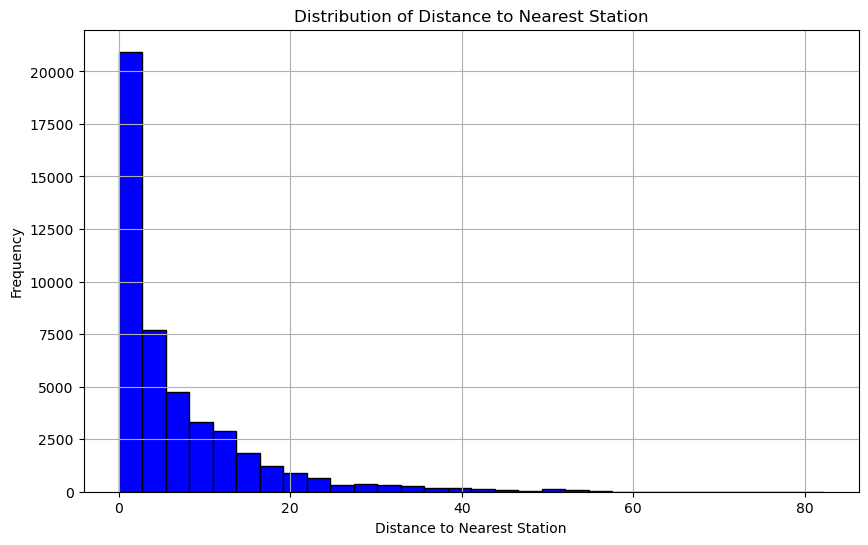

In [130]:
# Assuming 'distance_to_nearest_station' is the column name in bolig_df
plt.figure(figsize=(10, 6))
plt.hist(bolig_df_m_coordinates_u_BH['distance_to_nearest_station'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Distance to Nearest Station')
plt.xlabel('Distance to Nearest Station')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

In [133]:
bolig_df_m_coordinates_u_BH['distance_to_nearest_station'].describe()

count    46214.000000
mean         6.704769
std          8.387950
min          0.011158
25%          1.217213
50%          3.415941
75%          9.169468
max         82.168083
Name: distance_to_nearest_station, dtype: float64